## Capturing Sample Image of people for feeding the Model and Processing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2

## Creating Label

In [3]:
import numpy as  np

In [4]:
def my_label(image_name): #This function splits the filename (remove the .jpg extension)
    name = image_name.split('.')[-3]

    if name=="biplab":
        return np.array([1,0,0])
    elif name=="sanchari":
        return np.array([0,1,0])
    elif name=="sumi":
        return np.array([0,0,1])

## Creating Pictures into data format

In [5]:
import os
from random import shuffle
from tqdm import tqdm

In [6]:
def my_data(): #prepare data for model training from dataset
    data = [] #Initialize an empty data list to hold the corresponding pairs of images and labels.
    for img in tqdm(os.listdir("/content/drive/MyDrive/Data")):
        path=os.path.join("/content/drive/MyDrive/Data",img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        data.append([np.array(img_data), my_label(img)]) #Add pairs of images and labels to the data list
    shuffle(data) #Randomly shuffle the data in the list
    return data #Returns a prepared list of data.

In [7]:
data = my_data() #get the data and save it to the variable data

100%|██████████| 3000/3000 [00:36<00:00, 83.02it/s] 


## Splitting Data set into Training & Testing Data set

In [8]:
### split the data into two training and test sets,
#and convert them into a format suitable for use in training the CNN model

#Create a training set train from a data list containing the top 2400 images of the list
train = data[:2400]

#Create a test set from a data list containing images from position 2400 and below
test = data[2400:]

#Generate input data for training set X_train. then change the shape to
# (2400, 50, 50, 1) to fit the input dimensions of the CNN model (50x50x1).
# Chú thích: 2400 data samples, each with a size of 50x50 and a color channel (gray image).
X_train = np.array([i[0] for i in train]).reshape(-1,50,50,1)
print(X_train.shape)

#Create training label y_train
y_train = [i[1] for i in train]

#Generate input for test set X_test and change
#shape to (number of test samples, 50, 50, 1).
X_test = np.array([i[0] for i in test]).reshape(-1,50,50,1)
print(X_test.shape)

#Generate test label y_test
y_test = [i[1] for i in test]

(2400, 50, 50, 1)
(600, 50, 50, 1)


(2400, 50, 50, 1): This is the size of the X_train training set, i.e. there are 2400 training samples, each with size 50x50 and 1 color channel (gray image). This means that 2400 grayscale images of size 50x50 pixels were used to train the model.

(600, 50, 50, 1): This is the size of the X_test test set, i.e. there are 600 test samples, each with size 50x50 and 1 color channel (gray image). This means that 600 grayscale images of size 50x50 pixels are used to test the performance of the model after training.

## Creating Model now

build and train a Convolutional Neural Network (CNN) model for face recognition based on previously prepared data

In [9]:
!pip install tflearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127282 sha256=445dde6ca97e2bc169fd66cee1eca69ebf3ccb87bd57bdb6901b38e52dfa0708
  Stored in directory: /root/.cache/pip/wheels/55/fb/7b/e06204a0ceefa45443930b9a250cb5ebe31def0e4e8245a465
Successfully built tflearn


In [10]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
#Reset the calculation graph
#Defines the input layer of the model. The input size is [None, 50, 50, 1],
#where None represents a variable number of input samples and
#50x50x1 is the size of each image (50x50 pixels and 1 color channel - grayscale).
tf.compat.v1.reset_default_graph()
convnet = input_data(shape=[None, 50, 50, 1])

#Add a Convolutional layer with 32 filters, size 5x5 and ReLU activation function.
convnet = conv_2d(convnet, 32, 5, activation='relu')
#Add a Max Pooling layer with a 5x5 window size.
convnet = max_pool_2d(convnet, 5)
# Continue to add the same Convolutional and Max Pooling classes
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

#Add a fully connected layer with 1024 neurons and ReLU activation functions.
convnet = fully_connected(convnet, 1024, activation='relu')

#Apply dropout to avoid overfitting.
#Specifically, dropouts with a ratio of 0.8 are applied to the previous fully connected class.
convnet = dropout(convnet, 0.8)

#Add the last fully connected layer with 3 neurons (corresponding to 3 layers
# labeled "biplab", "sanchari", "sumi") and Softmax activation function to predict the layers.
convnet = fully_connected(convnet, 3, activation='softmax')

#Define loss functions and optimization algorithms to update network weights.
#In this case, using Adam optimization and the loss function is categorical crossentropy (due to the multi-class classification problem).
convnet = regression(convnet, optimizer='adam', learning_rate=0.001, loss='categorical_crossentropy')
#Create a DNN (Deep Neural Network) model object from the network architecture.convnet
model = tflearn.DNN(convnet, tensorboard_verbose=1)

# Change the shape of the training data again to fit the input size of the model (50x50x1).X_train
X_train = X_train.reshape([-1, 50, 50, 1])
#Change back the shape of the test data to match the input size of the model (50x50x1).X_test
X_test = X_test.reshape([-1, 50, 50, 1])

#Train the model using training data and labels in 12 epochs (training loops).
#Test data and are used to evaluate the model's performance during training.
#At the same time, display evaluation parameters (metrics) during training via parameters.
#Finally, name the training process by .X_trainy_trainX_testy_testshow_metric=Truerun_id="FRS"
model.fit(X_train, y_train, n_epoch=12, validation_set=(X_test, y_test), show_metric=True, run_id="FRS")


Training Step: 455  | total loss: 0.00037 | time: 1.269s
| Adam | epoch: 012 | loss: 0.00037 - acc: 0.9999 -- iter: 2368/2400
Training Step: 456  | total loss: 0.00034 | time: 2.306s
| Adam | epoch: 012 | loss: 0.00034 - acc: 0.9999 | val_loss: 0.00002 - val_acc: 1.0000 -- iter: 2400/2400
--


- 'Training Step: 455': This is the 455th training step in 12 epochs.

- 'total loss: 0.00037': Total loss value

### <u>After Training the model </u>
### Validation Accuracy = 1.00
### Validation Loss = 0.00002

# ___________________________________________

#   
# <u> Now visualize the data and make prediction </u>

load data from the Drive directory after the model has been trained, to test the predictive performance of the model on new images never before seen.visualization_Data()

In [12]:
def visualization_Data():
    Vdata = []
    for img in tqdm(os.listdir("/content/drive/MyDrive/visualization images")):
        path = os.path.join("/content/drive/MyDrive/visualization images", img)
        img_num = img.split('.')[0]
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        Vdata.append([np.array(img_data), img_num])
    shuffle(Vdata)
    return Vdata

In [13]:
Vdata = visualization_Data()

100%|██████████| 60/60 [00:13<00:00,  4.56it/s]


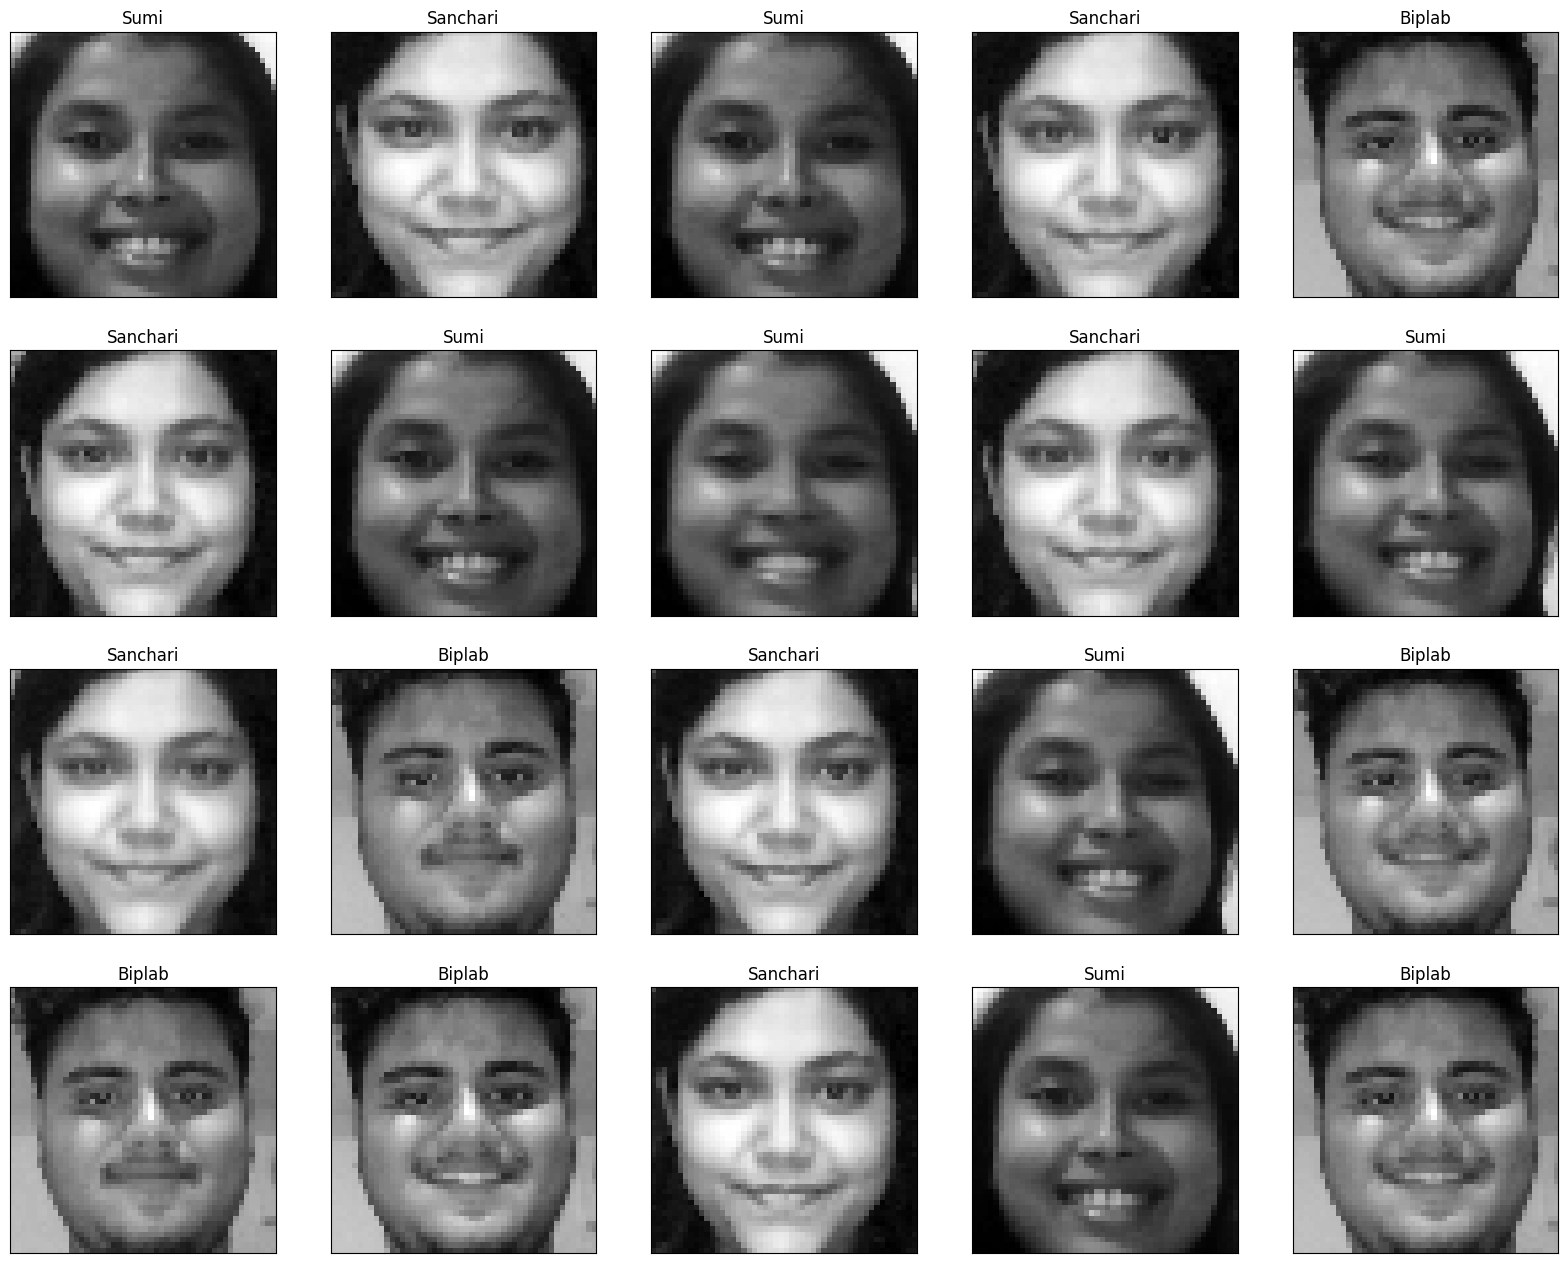

In [14]:
# performs the rendering of 20 images from the dataset


import matplotlib.pyplot as plt
#Create a 20x20-inch Figure object.
#Figure objects are an advanced class of matplotlib, representing a
#drawing containing axes and other graphic elements.
fig = plt.figure(figsize=(20,20))
for num, data in enumerate(Vdata[:20]):
    img_data = data[0]
    #Add a subplot to the 5x5 drawing and the index is .
    #Notice that the subplot index starts at 1.num+1
    y = fig.add_subplot(5,5, num+1)

    #Assign image data to a variable to display.image
    image = img_data

    #Adjust the size of the image data to 50x50x1 using .reshape()
    data = img_data.reshape(50,50,1)

    #The prediction returns a probability vector for each class (3 classes in this case),
    # and we get the class number with the highest probability
    model_out = model.predict([data])[0]

    #Based on the predicted results, specify the label name of the image (biplab, sanchari, sumi)
    if np.argmax(model_out) == 0:
        my_label = 'Biplab'
    elif np.argmax(model_out) == 1:
        my_label = 'Sanchari'
    else:
        my_label = 'Sumi'

    #Displays images in subplots used with cmap='gray' to display gray images.imshow()
    y.imshow(image, cmap='gray')
    plt.title(my_label)

    #Hides the x-axis and y-axis of the subplot.
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

## Confusion Matrix

#calculates and displays the Confusion Matrix after having trained the model and tested the performance on the test set.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

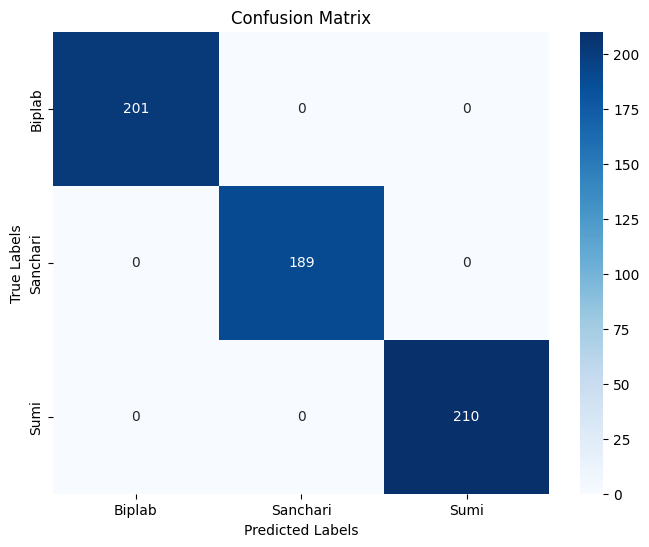

In [16]:

y_pred = []
for data in X_test:
    #: Predict the class of the current sample from the trained model.
    prediction = model.predict([data])[0]
    # Determine the class index with the highest probability in the predicted result
    predicted_label = np.argmax(prediction)
    #Add the predicted result to the list
    y_pred.append(predicted_label)

#Specifies the actual class index from the label set
y_true = np.argmax(y_test, axis=1)

#Confusion Matrix calculations by comparing actual labels and predictive
cm = confusion_matrix(y_true, y_pred)

#Defines the names of classes for use in the Confusion Matrix.
class_labels = ['Biplab', 'Sanchari', 'Sumi']

#Create a Figure object and axes to draw the Confusion Matrix with dimensions of 8x6 inches.
fig, ax = plt.subplots(figsize=(8, 6))

#Draw the Confusion Matrix as a heatmap with values inside the cell and layer labels displayed next to it.
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)


ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

plt.show()